In [4]:
# import gfapy
import networkx as nx
import gzip
import pyfrost
import numpy
from collections import defaultdict
import matplotlib.pyplot as plot
import sys
sys.path.append('../../MHC_asm/')
#import CCGG_extension as CCGG
import json

In [2]:
#! pip3 install matplotlib

In [3]:
#sys.path

In [4]:
#! ls /home/linuxbrew/.linuxbrew/opt/python@3.11/lib/python3.11/lib-dynload

In [3]:
filename = './MT_graph_Bfrost_graph.gfa'
g = pyfrost.load(filename)

OSError: Could not find graph GFA file MT_graph_Bfrost_graph.gfa

In [42]:
len(g.graph['color_names']), g.graph['k']

(47, 31)

In [5]:
def revised_find_shared_kmers(g, k, colorsnum):
    anchorlist = []
    no_colors = 0
    for n, data in g.nodes(data=True):
        unitig = data['unitig_sequence']
        for i in range(len(unitig)- k + 1):
            n = unitig[i:i+k]
            try:
                colors = g.nodes[pyfrost.Kmer(n)]['colors'] 
                if len(set(colors)) == colorsnum:
                    anchorlist.append(n)
                    break
            except:
                no_colors += 1
                
    return anchorlist, no_colors

anchorlist, no_colors = revised_find_shared_kmers(g, 31, 47)
no_colors, len(anchorlist)

NameError: name 'g' is not defined

In [44]:
len(list(g.nodes)), no_colors, no_colors/len(list(g.nodes))

(137798, 1210206, 8.78246418670808)

In [ ]:
# using new anchor list with

In [45]:
# map to reference, delete duplicated or missing kmers (exist in reverse complement strand)
refgenome = '/home/suhang/assembly_disk/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)
contig = "+" + contig # reference sequences

In [46]:

def map_to_genome(contig, anchorlist, k):
    PositionDict = defaultdict(list)
    for anchor in anchorlist:
        PositionDict[anchor]
    for i in range(1, len(contig) - k + 1):
        kmer = contig[i:i+k]
        if kmer in PositionDict:
            PositionDict[kmer] = PositionDict.get(kmer, []) + [i]
    return PositionDict



In [47]:
def create_anchors(PositionDict, k):
    anchor_updated_list = []

    for kmer in PositionDict:
        if len(PositionDict[kmer]) == 1:
            anchor_updated_list.append(kmer)
    AnchorInfo = {}
    for kmer in anchor_updated_list:
        pos = PositionDict[kmer][0]
        anchorname = "A%06d" %  (pos//k + 1)
        AnchorInfo[anchorname] = {}
        AnchorInfo[anchorname]['seq'] = kmer
        AnchorInfo[anchorname]['pos'] = pos
        
    anchornames = sorted(AnchorInfo.keys())
    anchor_unadjacent_list = []
    index = 0
    sanchor = anchornames[index]
    while sanchor < anchornames[-1]:
        for danchor in anchornames[index+1:]:
            if AnchorInfo[danchor]['pos'] - AnchorInfo[sanchor]['pos'] > k+1:
                break
            index += 1
        anchor_unadjacent_list += [sanchor, danchor]
        sanchor = danchor
    anchor_unadjacent_list = sorted(set(anchor_unadjacent_list))[:-1]
    return AnchorInfo, anchor_unadjacent_list

In [48]:
k = 31
PositionDict = map_to_genome(contig, anchorlist, k)
AnchorInfo, anchor_unadjacent_list = create_anchors(PositionDict, k)

In [54]:
#anchor_unadjacent_list = sorted(set(anchor_unadjacent_list))
print(len(anchor_unadjacent_list), len(AnchorInfo))
pos1 = [AnchorInfo[anchor]['pos'] for anchor in anchor_unadjacent_list[1:]]
pos = [AnchorInfo[anchor]['pos'] for anchor in anchor_unadjacent_list[:-1]]
numpy.where((numpy.array(pos1) - numpy.array(pos))<=k), k

316 513


((array([], dtype=int64),), 31)

In [55]:
Final_anchor = {anchor:AnchorInfo[anchor] for anchor in anchor_unadjacent_list}
len(Final_anchor)

316

In [56]:
# load raw reads
def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained.
        The resulting sequences are 0-indexed! """
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rb')
    else:
        fp = open(filename, 'rb')
    # split at headers
    data = fp.read().decode().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        sequences.append(''.join(lines))
    return (headers, sequences)

In [57]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/all.fasta'
headers, sequences = loadFasta(filename)

In [58]:
refgenome = '/home/suhang/assembly_disk/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)

headers.append('NC_012920')
sequences.append(contig)

In [59]:
#headers

In [60]:


def mapping_info(AnchorInfo, contig, k):
    anchor_list = list(AnchorInfo.keys())
    Anchorseq = {AnchorInfo[anchor]['seq']:anchor for anchor in anchor_list}

    seqlist = Anchorseq.keys()
    PositionDict = defaultdict(list)
    for anchor_seq in seqlist:
        anchor_rev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(anchor_seq)])
        PositionDict[anchor_seq]
        PositionDict[anchor_rev]

    for i in range(1, len(contig) - k + 1):
        kmer = contig[i:i+k]
        if kmer in PositionDict:
            PositionDict[kmer] = PositionDict.get(kmer, []) + [i]
            
    A = {}
    SVs = {}
    for anchor, D in AnchorInfo.items():
        anchor_seq = D['seq']
        anchor_rev = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(anchor_seq)])
        poslist = PositionDict[anchor_seq] + PositionDict[anchor_rev]
        if len(poslist) == 1:
            A[anchor] = poslist[0]
        else:
            SVs[anchor] = poslist
            
    return A, SVs

def find_edge_info(src_pos, dst_pos, k, contig, contigname, sample, Anchorseq):
    E = {} # edgeinfo
    # get source infomation
    if src_pos == 0:
        src = "SOURCE"
        src_seq = ""
        pr = False
    else:
        src_seq = contig[src_pos:src_pos + k]
        try:
            src = Anchorseq[src_seq]
            pr = False
        except:
            src_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(src_seq)])
            src = Anchorseq[src_seq]
            pr = True

    dst_seq = contig[dst_pos:dst_pos+k]
    
    if dst_pos == len(contig): # fix sink edge issue 08/29/23
        dst = "SINK"
        dst_seq = ""
        sr = True
    else:
        try:
            dst = Anchorseq[dst_seq]
            sr = False
        except:
            dst_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(dst_seq)])
            dst = Anchorseq[dst_seq]
            sr = True
            
    if src_pos == 0:
        edge_seq = contig[src_pos:dst_pos] # first edge fix bug 08/28/2023
    else:
        edge_seq = contig[src_pos+k:dst_pos] # fix bug 08/23/2023
        
    if pr and sr:
        edge_seq = ''.join([{'A':'T','C':'G','G':'C','T':'A'}[base] for base in reversed(edge_seq)])
        node = src
        src = dst
        dst = node

    
    E = {}
    E['seq'] = edge_seq
    E['src'] = src
    E['dst'] = dst
    E['reads'] = [contigname]
    E['strain'] = [sample]


    return E


In [61]:
# loop through all reads
def create_edgefile(headers, sequences, AnchorInfo, k):
    Edge_info = {}
    Outgoing = {}
    
    edgenum_perread = []
    anchor_list = list(AnchorInfo.keys())
    Anchorseq = {AnchorInfo[anchor]['seq']:anchor for anchor in anchor_list}
    
    for contig_index in range(len(headers)):
        contig = sequences[contig_index]
        contig_name = headers[contig_index]
        sample_name = contig_name.split('_')[-1]
        A, SVs = mapping_info(AnchorInfo, contig, k)
        splitposlist = sorted(A.values())
        edgeindex = 0 # 
        src_pos = 0
        for dst_pos in splitposlist:
            E = find_edge_info(src_pos, dst_pos, k, contig, contig_name, sample_name, Anchorseq)
            src = E['src']
            edgelist = Outgoing.get(src, [])
            for edge in edgelist:
                if Edge_info[edge]['dst'] != E['dst']:
                    continue
                if Edge_info[edge]['seq'] == E['seq']:
                    Edge_info[edge]['reads'] += E['reads']
                    Edge_info[edge]['strain'] = sorted(set(Edge_info[edge]['strain']) | set(E['strain']))
                    break
            else:
                edgename = "E%05d.%04d" % (contig_index, edgeindex)
                Edge_info[edgename] = E
                Outgoing[src] = Outgoing.get(src,[]) + [edgename]
                edgeindex += 1
            # update
            src_pos = dst_pos
        
        dst_pos = len(contig) # fix bug 08/29/2023 
        E = find_edge_info(src_pos, dst_pos, k, contig, contig_name, sample_name, Anchorseq)
        src = E['src']
        edgelist = Outgoing.get(src, [])
        for edge in edgelist:
            if Edge_info[edge]['dst'] != E['dst']:
                continue
            if Edge_info[edge]['seq'] == E['seq']:
                Edge_info[edge]['reads'] += E['reads']
                Edge_info[edge]['strain'] = sorted(set(Edge_info[edge]['strain']) | set(E['strain']))
                break
        else:
            edgename = "E%05d.%04d" % (contig_index, edgeindex)
            Edge_info[edgename] = E
            Outgoing[src] = Outgoing.get(src,[]) + [edgename]
            edgeindex += 1
        
        edgenum_perread.append(edgeindex)   
        
    return Edge_info, Outgoing
        #print(contig_name, edgeindex)




In [64]:
#Final_anchor
#k = 11
#len(Anchorseq)

In [65]:
%time Edge_info, Outgoing = create_edgefile(headers, sequences, Final_anchor, k)

CPU times: user 4min 42s, sys: 192 ms, total: 4min 42s
Wall time: 4min 42s


In [20]:
list(Edge_info.keys())[0], Edge_info['E00000.0000'], len(Edge_info)

('E00000.0000',
 {'seq': 'AAACCTGCCCCTACTCCTCCTAGACCTAACCTGACTAGAAAAGCT',
  'src': 'SOURCE',
  'dst': 'A000453',
  'reads': ['m54329U_201103_231616/6359354/ccs_HG002'],
  'strain': ['HG002']},
 124156)

In [21]:
def filter_undersupported_edges(Edge_info, ref = 'NC_012920', threshold = 4):
    # filter edges that supported by > 3 reads
    deleted_edge = []
    for edge in Edge_info:
        if ref in Edge_info[edge]['reads']:
            continue
        if len(Edge_info[edge]['reads']) < 4:
            deleted_edge.append(edge)
    print(len(deleted_edge))
    for edge in deleted_edge:
        del Edge_info[edge]
    return 

In [22]:
filter_undersupported_edges(Edge_info)

113421


In [23]:
anchor = anchor_unadjacent_list[0]
AnchorInfo[anchor]

{'seq': 'GTCTATCACCCTATTAACCACTCACGGGAGC', 'pos': 9}

In [24]:
# Write Graph into fa files
import ujson as json
def writeGraphFasta(filename, input_dict, keylist=["src", "dst"]):
    """Write the given node or edge file as a FASTA file. Overwrites existing file. Will create file if it doesn't exist. 
    def writeFasta(self:<GraphicalGenome>, filename:<str>, input_dict:<dict>, keylist=["src","dst"]:<list[str]>) -> Void

    Parameters:
        filename: <str> - absolute path for the file you wish to write. 
        input_dict: <dict> - Node or Edge dictionary you wish to write. 
        keylist: <list[str]> - list of strings of dictionary keys that you want to ignore during write. 
                This will require you to write these values on your own or just discard them. 
    """
    sorted_keys = sorted(input_dict.keys()) 
    with open(filename, "w+") as fastafile:
        # If iterating through the edges, write the edges in the correctly ordered format
        if (sorted_keys[0][0] == "E"):
            for edge in sorted_keys:
                # If header has not been evaluated, just re-write the header wholesale without any analysis
                if "hdr" in input_dict[edge].keys():
                    line = ">" + edge + ";" + input_dict[edge]["hdr"] + "\n"
                    line += input_dict[edge]["seq"] + "\n"
                    continue
                line = ">" + edge + ";{" 
                # Source
                line += '"src":"' + input_dict[edge]["src"] + '",'
                # Destination
                line += '"dst":"' + input_dict[edge]["dst"] + '"'
                for key in input_dict[edge].keys():
                    if key == "seq":
                        continue
                    if key in keylist:
                        continue
                    line += ',"' + key + '":' + json.dumps(input_dict[edge][key], separators=(",", ":"))
                line += "}\n"
                line += input_dict[edge]["seq"] + "\n"
                fastafile.write(line)
        # If iterating over nodes, just write the nodes normally
        else:
            for i in sorted_keys:
                line = ">" + i + ";"
                obj = {}
                for j in input_dict[i].keys():
                    if j == 'seq':
                        continue
                    obj[j] = input_dict[i][j]
                #print(type(obj), obj)
                line += json.dumps(obj, separators=(",", ":"))
                line += "\n" + input_dict[i]['seq'] + "\n"
                fastafile.write(line)



In [25]:
writeGraphFasta("/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/MT_HPRC_nodes.fa",Final_anchor)
writeGraphFasta("/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/MT_HPRC_edges.fa",Edge_info)

In [15]:
# To do add RC tag to the edge files, read count

def write_gfa(AnchorInfo, Edge_info, outputfilename):
    header = ['H\tVN:Z:1.0\n']
    # add json annotation to edge and anchor sequences
    AnchorS = []
    for anchor,D in AnchorInfo.items():
        seq = D.pop('seq')
        json_string = json.dumps(D)
        AnchorS += ['S\t%s\t%s\t%s\n' % (anchor, seq, "PG:J:" + json_string)]
   
    EdgeS = []   
    Link = [] 
    for edge,edge_dict in Edge_info.items():
        seq = edge_dict.pop('seq')
        src = edge_dict.pop('src')
        dst = edge_dict.pop('dst')
        
        json_string = json.dumps(edge_dict)
        EdgeS += ['S\t%s\t%s\t%s\t%s\n' % (edge, seq, "PG:J:" + json_string, "RC:i:" + str(len(edge_dict['reads'])))]
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (src, "+", edge, "+", "0M"))
        Link.append('L\t%s\t%s\t%s\t%s\t%s\n'% (edge, "+", dst, "+", "0M"))     

    with open(outputfilename, 'w') as fp:
        for h in header:
            fp.write(h)
        for s in AnchorS:
            fp.write(s)
        for s in EdgeS:
            fp.write(s)
        for l in Link:
            fp.write(l)

In [27]:
filename = '/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/MT_anchor_graphical_genome_k31_withannotation.gfa'
write_gfa(Final_anchor, Edge_info, filename)

# Results

In [4]:
# load graph from gfa

class GraphicalGenome:
    def __init__(self, filename):
        self.anchor, self.edges, self.outgoing, self.incoming = self.loadgraph(filename)

    def loadgraph(self, filename):
        if filename.endswith(".gz"):
            with gzip.open(filename, 'rb') as fp:
                data = fp.readlines()
        else:
            with open(filename, 'rb') as fp:
                data = fp.readlines()
        Anchor_dict = {}
        Edge_dict = {}
        Outgoing = {}
        Incoming = {}

        for line in data:
            line = line.decode()[:-1]
            if line.startswith("S"):
                itemlist = line.split('\t')
                name = itemlist[1]
                seq = itemlist[2]
                annotation = itemlist[3][5:]
                if name.startswith("A"):
                    Anchor_dict[name] = json.loads(annotation)
                    Anchor_dict[name]['seq'] = seq
                elif name.startswith("E"):
                    Edge_dict[name] = json.loads(annotation)
                    Edge_dict[name]['seq'] = seq
            elif line.startswith("L"):
                itemlist = line.split('\t')
                src = itemlist[1]
                dst = itemlist[3]
                Outgoing[src] = Outgoing.get(src, []) + [dst]
                Incoming[dst] = Incoming.get(dst, []) + [src]
#                 if src.startswith('A') or src == "SOURCE":
#                     assert dst.startswith("E")
#                     Outgoing[src] = Outgoing.get(src, []) + [dst]
#                 elif dst.startswith("A") or dst == "SINK":
#                     assert src.startswith("E")
#                     Incoming[dst] = Incoming.get(dst, []) + [src]
                    
        return Anchor_dict, Edge_dict, Outgoing, Incoming

In [9]:
# load graph
filename = './test.gfa'
graph = GraphicalGenome(filename)

# nodefile = "/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/MT_HPRC_nodes.fa"
# edgefile = "/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/MT_HPRC_edges.fa"
# graph = CCGG.GraphicalGenome(nodefile, edgefile, nnamelen=7, enamelen=11)

In [10]:
#graph.edges.keys()

In [11]:
# Outgoing = {}
# Incoming = {}
# edgelist = list(graph.edges.keys())
# for edge in edgelist:
#     src = graph.edges[edge]['src']
#     dst = graph.edges[edge]['dst']
#     Outgoing[src] = Outgoing.get(src, []) + [edge]
#     Incoming[dst] = Incoming.get(dst, []) + [edge]

In [44]:
nodelist = list(graph.anchor.keys())
edgelist = list(graph.edges.keys())
graph_size = sum([len(graph.anchor[node]['seq']) for node in nodelist]) + sum([len(graph.edges[edge]['seq']) for edge in edgelist])

In [18]:
sum(len(seq) for seq in sequences), graph_size/float(sum(len(seq) for seq in sequences))

NameError: name 'sequences' is not defined

Text(0, 0.5, 'Num of Anchor')

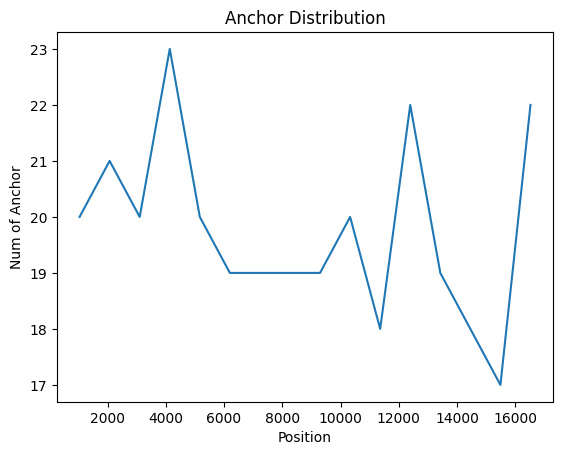

In [45]:
Anchor_position = sorted([graph.anchor[node]['pos'] for node in nodelist])

y, x = numpy.histogram(Anchor_position, bins = 16)
plot.plot(x[1:], y)
plot.title("Anchor Distribution")
plot.xlabel("Position")
plot.ylabel("Num of Anchor")

Text(0.5, 1.0, 'Outdegree Distribution')

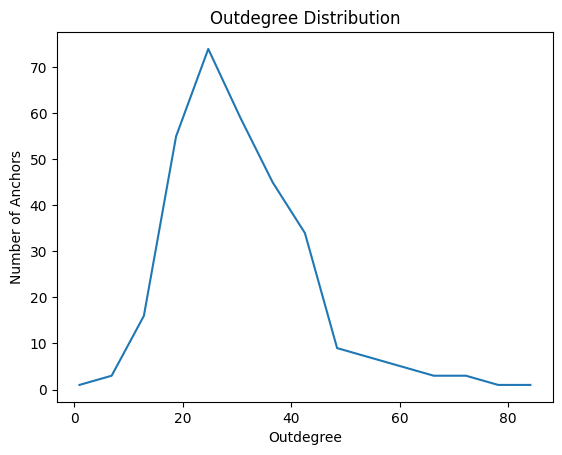

In [47]:
outdegree = []
nodelist = list(graph.anchor.keys())
#nodelist.remove("SOURCE")
for node in nodelist:
    outdegree.append(len(graph.outgoing[node]))
    
y,x = numpy.histogram(outdegree, bins = 15)
plot.plot(x[:-1], y)
#plot.xlim([0,1000])
plot.xlabel("Outdegree")
plot.ylabel("Number of Anchors")
plot.title("Outdegree Distribution")

# check sample information

In [48]:
sample = "HG002"
edgelist = list(graph.edges.keys())
for edge in edgelist:
    if sample in graph.edges[edge]['strain']:
        break

In [12]:
def reconstruct_refpath(ref = 'NC_012920.1'):
    src = "SOURCE"
    Path = []

    visited = set()

    while src != "SINK":
        edgelist = graph.outgoing[src]
        ref_edge = []
        for edge in edgelist:
            if ref in graph.edges[edge]['reads']:
                ref_edge += [edge]
        if len(ref_edge) == 1:
            edge = ref_edge[0]
        else:
            for edge in ref_edge:
                if graph.outgoing[edge] == "SINK":
                    break
        Path += [src, edge]
        visited.add(src)
        src = graph.outgoing[edge][0]
        assert src.startswith("A") or src == "SINK"
        if src in visited:
            break
            
    reconstruct = ''
    for item in Path:
        if item == "SOURCE":
            reconstruct += ""
        elif item.startswith('A'):
            reconstruct += graph.anchor[item]['seq']
        elif item.startswith("E"):
            reconstruct += graph.edges[item]['seq']
        else:
            print(item)
    return reconstruct, Path

In [13]:
reconstruct_ref, Path = reconstruct_refpath()

In [14]:
# map to reference, delete duplicated or missing kmers (exist in reverse complement strand)
refgenome = '/home/suhang/assembly_disk/Mitochondrial/NC_012920.1.fasta'
with open(refgenome, 'r') as fp:
    data = fp.readlines()
kmers = [k[:-1] for k in data[1:]]
contig = "".join(kmers)

assert reconstruct_ref == contig
print("PASS")

PASS


In [34]:
Path[-1]

'E11922.0007'

In [30]:
print(len(reconstruct_ref), len(contig), graph.outgoing['E06834.0001'], )
for edge in graph.incoming['SINK']:
    if "012920.1" in graph.edges[edge]['strain']:
        print(edge, graph.edges[edge], graph.outgoing[edge])
        break

16569 16569 ['A000001']
E11922.0007 {'reads': ['NC_012920.1'], 'strain': ['012920.1'], 'seq': 'AATAAGACATCACGATG'} ['SINK']


In [15]:
contig[:10], contig[-10:]


('GATCACAGGT', 'CATCACGATG')

# reconstruct sample subgraph
# reconstruct most supported path for each sample

In [15]:
# load graph
filename = './test.gfa'
graph = GraphicalGenome(filename)

samplelist = ["HG002"]


In [33]:
def reconstruct_sample_subgraph(graph, samplelist, outputfile):
    Anchor_dict = {}
    Edge_dict = {}
    edgelist = list(graph.edges.keys())
    Anchor_dict = {}
    Edge_dict = {}
    nodelist = []
    for edge in edgelist:
        if len(set(samplelist) & set(graph.edges[edge]['strain'])) > 0:
            Edge_dict[edge] = graph.edges[edge]
            Edge_dict[edge]['src'] = graph.incoming[edge][0]
            Edge_dict[edge]['dst'] = graph.outgoing[edge][0]
        nodelist += graph.incoming[edge]
        nodelist += graph.outgoing[edge]

    nodelist = list(set(nodelist))
    for node in nodelist:
        if node.startswith("A"):
            Anchor_dict[node] = graph.anchor[node]
            
    write_gfa(Anchor_dict, Edge_dict, outputfile)
    
    return Anchor_dict, Edge_dict


In [21]:
list(graph.edges.keys())[0], graph.edges['E00000.0001']['strain']

('E00000.0001',
 ['012920.1',
  'HG002',
  'HG00438',
  'HG00621',
  'HG00673',
  'HG00733',
  'HG01071',
  'HG01106',
  'HG01109',
  'HG01123',
  'HG01175',
  'HG01243',
  'HG01258',
  'HG01358',
  'HG01361',
  'HG01891',
  'HG01928',
  'HG01952',
  'HG01978',
  'HG02055',
  'HG02080',
  'HG02109',
  'HG02145',
  'HG02148',
  'HG02486',
  'HG02559',
  'HG02572',
  'HG02622',
  'HG02630',
  'HG02717',
  'HG02723',
  'HG02818',
  'HG02886',
  'HG03098',
  'HG03453',
  'HG03486',
  'HG03516',
  'HG03540',
  'HG03579',
  'NA18906',
  'NA19240',
  'NA20129',
  'NA21309'])

In [31]:
# find the most supported path for a sample
sample = "HG002"

def find_most_supported_path(graph, sample, ref = '012920.1'):
    src = "SOURCE"
    Path = []

    visited = set()

    while src != "SINK":
        edgelist = graph.outgoing[src]
        sample_edge = []
        for edge in edgelist:
            if sample in set(graph.edges[edge]['strain']):
                sample_edge += [edge]
        if len(sample_edge)<1: # no haplotype for this sample at this place the go to the reference one
            for edge in edgelist:
                if ref in set(graph.edges[edge]['strain']):
                    break
            
        elif len(sample_edge) == 1:
            edge = sample_edge[0]
        else:
            # find the most supported edge
            read_count = [len(graph.edges[e]['reads']) for e in sample_edge]

            index = numpy.argmax(read_count)

            edge = sample_edge[index]


        Path += [src, edge]

        visited.add(src)

        src = graph.outgoing[edge][0]

        assert src.startswith("A") or src == "SINK"

        if src in visited:
            break

    reconstruct = ''
    for item in Path:
        if item == "SOURCE":
            reconstruct += ""
        elif item.startswith('A'):
            reconstruct += graph.anchor[item]['seq']
        elif item.startswith("E"):
            reconstruct += graph.edges[item]['seq']
        else:
            print(item)
            
    return reconstruct, Path

In [35]:
sample

'HG002'

In [40]:
# reads supporting this path
sample = "HG00438"
def read_sets_supporting_path(graph, sample, Path):
    read_sets = set()
    for item in Path:
        if item.startswith("E"):
            readlist = graph.edges[item]['reads']
            for read in readlist:
                if read.endswith(sample):
                    read_sets.add(read)
    return read_sets

In [41]:
read_sets_supporting_path(graph,sample, Path)

{'m64043_200710_174426/100074720/ccs_HG00438',
 'm64043_200710_174426/103352008/ccs_HG00438',
 'm64043_200710_174426/103743762/ccs_HG00438',
 'm64043_200710_174426/109445286/ccs_HG00438',
 'm64043_200710_174426/10946429/ccs_HG00438',
 'm64043_200710_174426/1116/ccs_HG00438',
 'm64043_200710_174426/111804746/ccs_HG00438',
 'm64043_200710_174426/116654474/ccs_HG00438',
 'm64043_200710_174426/11666850/ccs_HG00438',
 'm64043_200710_174426/117309824/ccs_HG00438',
 'm64043_200710_174426/118032691/ccs_HG00438',
 'm64043_200710_174426/119931589/ccs_HG00438',
 'm64043_200710_174426/120391219/ccs_HG00438',
 'm64043_200710_174426/120522738/ccs_HG00438',
 'm64043_200710_174426/120784443/ccs_HG00438',
 'm64043_200710_174426/12518004/ccs_HG00438',
 'm64043_200710_174426/125305117/ccs_HG00438',
 'm64043_200710_174426/125569156/ccs_HG00438',
 'm64043_200710_174426/133498649/ccs_HG00438',
 'm64043_200710_174426/133761440/ccs_HG00438',
 'm64043_200710_174426/13960288/ccs_HG00438',
 'm64043_200710_174426

In [30]:
strain = set()
for edge in graph.outgoing["SOURCE"]:
    strain = strain | set(graph.edges[edge]['strain'])
strain

{'012920.1',
 'HG00438',
 'HG00673',
 'HG00733',
 'HG00735',
 'HG01109',
 'HG01123',
 'HG01175',
 'HG01243',
 'HG01258',
 'HG01358',
 'HG01361',
 'HG01891',
 'HG01952',
 'HG02055',
 'HG02080',
 'HG02109',
 'HG02145',
 'HG02148',
 'HG02257',
 'HG02572',
 'HG02630',
 'HG02717',
 'HG02723',
 'HG02818',
 'HG02886',
 'HG03453',
 'HG03486',
 'HG03492',
 'HG03516',
 'HG03540',
 'HG03579',
 'NA18906',
 'NA19240',
 'NA20129',
 'NA21309'}

In [32]:
reconstruct, Path = find_most_supported_path(graph, sample)

In [43]:
# Path

In [44]:
graph.anchor['A000001']

{'pos': 9, 'seq': 'GTCTATCACCCTATTAACCACTCACGGGAGC'}

In [35]:
Anchor_dict, Edge_dict = reconstruct_sample_subgraph(graph, samplelist, "test.hg002.gfa")

In [43]:
 #graph.edges['E11922.0007'], graph.nodes['A000534']

In [44]:
16538+31, contig[16538+1:16538 +1+ 31]

(16569, 'CACGTTCCCCTTAAATAAGACATCACGATG')

In [45]:
nodelist = list(graph.nodes.keys())
ref_contig = "+" + contig
for node in nodelist:
    seq = graph.nodes[node]['seq']
    pos = int(graph.nodes[node]['pos'])
    assert seq == ref_contig[pos:pos + 31], print(node)

In [46]:
node, graph.nodes[node]['seq'], pos, ref_contig[pos:pos + 31]

('A000533',
 'TAAAGCCTAAATAGCCCACACGTTCCCCTTA',
 16522,
 'TAAAGCCTAAATAGCCCACACGTTCCCCTTA')

In [12]:
#graph.edges['E00000.0047']